<a href="https://colab.research.google.com/github/regiiis/pv_error_classification/blob/main/pv_error_classifcation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DLV Group Project - **Semantic Segmentation**



## Set Up

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Feb 28 18:21:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# General imports
import pandas as pd
import numpy as np
from numpy import asarray
from numpy import savetxt
from numpy import genfromtxt
import os, datetime
import sys
import math
import random

# Import graph plotting lib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Imoprt tensorflow and set to eager execution
import tensorflow as tf
tf.compat.v1.enable_eager_execution(
    config=None, device_policy=None, execution_mode=None
)

# Shortcuts to keras
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.utils import array_to_img
from IPython.display import Image

# Performance tools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

#from PIL import Image
#from PIL import Image as im
#from skimage.transform import resize

# NN visualisation
!pip3 install visualkeras
import visualkeras
from collections import defaultdict
from PIL import ImageFont

In [3]:
# Import drive and allow access
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Unzip data on Google Drive

!unzip "/content/drive/My Drive/Colab Notebooks/data/2020-02-14_InfraredSolarModules.zip"

Archive:  /content/drive/My Drive/Colab Notebooks/data/2020-02-14_InfraredSolarModules.zip
replace InfraredSolarModules/module_metadata.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace InfraredSolarModules/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [5]:
# Load data into df

df = pd.read_json("/content/InfraredSolarModules/module_metadata.json",orient="index")
df['image_name'] = df['image_filepath'].str[7:]
df = df.sort_index()
df

,image_filepath,anomaly_class,image_name
0,images/0.jpg,Offline-Module,0.jpg
1,images/1.jpg,Offline-Module,1.jpg
2,images/2.jpg,Offline-Module,2.jpg
3,images/3.jpg,Offline-Module,3.jpg
4,images/4.jpg,Offline-Module,4.jpg
...,...,...,...
19995,images/19995.jpg,No-Anomaly,19995.jpg
19996,images/19996.jpg,No-Anomaly,19996.jpg
19997,images/19997.jpg,No-Anomaly,19997.jpg
19998,images/19998.jpg,No-Anomaly,19998.jpg


## Explore Data

In [6]:
# Display all categories

categories = df["anomaly_class"].unique()
list(categories)

['Offline-Module',
 'Diode-Multi',
 'Diode',
 'Shadowing',
 'Cell-Multi',
 'Cell',
 'Hot-Spot',
 'Cracking',
 'Hot-Spot-Multi',
 'Soiling',
 'Vegetation',
 'No-Anomaly']

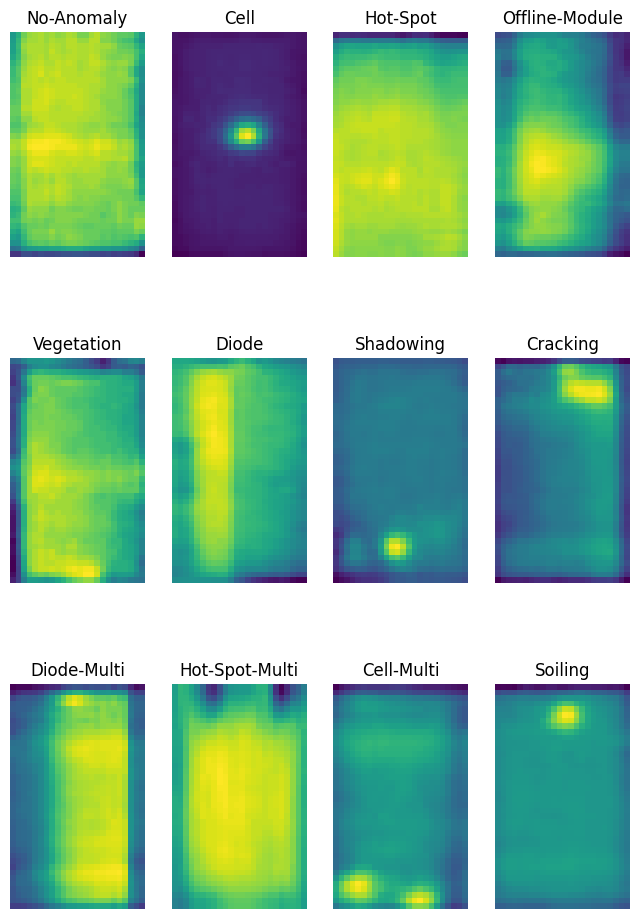

In [7]:
# Select and display a iamge for each category

df.groupby('anomaly_class').head(1)
img1 = mpimg.imread('/content/InfraredSolarModules/images/13357.jpg') #No-Anomaly
img2 = mpimg.imread('/content/InfraredSolarModules/images/5988.jpg')  #Cell
img3 = mpimg.imread('/content/InfraredSolarModules/images/6796.jpg')  #Hot-Spot
img4 = mpimg.imread('/content/InfraredSolarModules/images/270.jpg')  #Offline-Module
img5 = mpimg.imread('/content/InfraredSolarModules/images/9528.jpg') #Vegetation
img6 = mpimg.imread('/content/InfraredSolarModules/images/2143.jpg')  #Diode
img7 = mpimg.imread('/content/InfraredSolarModules/images/3519.jpg')  #Shadowing
img8 = mpimg.imread('/content/InfraredSolarModules/images/7188.jpg')  #Cracking
img9 = mpimg.imread('/content/InfraredSolarModules/images/876.jpg') #Diode-Multi
img10 = mpimg.imread('/content/InfraredSolarModules/images/8019.jpg')  #Hot-Spot-Multi
img11 = mpimg.imread('/content/InfraredSolarModules/images/4592.jpg')  #Cell-Multi
img12 = mpimg.imread('/content/InfraredSolarModules/images/8291.jpg')  #Soiling

#create list of image name
list_img = []
for i in range(12):
  list_img.append(f"img{i+1}")

# Create list of category names
list_categories = ['No-Anomaly','Cell','Hot-Spot','Offline-Module','Vegetation','Diode','Shadowing',
            'Cracking','Diode-Multi','Hot-Spot-Multi','Cell-Multi','Soiling']

# Plot images
fig = plt.figure(figsize=(8, 12))
columns = 4
rows = 3
for i,n in zip(range(1, columns*rows +1), list_categories):
    img = f"img{i}"
    fig.add_subplot(rows, columns, i)
    plt.imshow(globals()[img])
    plt.title(n)
    plt.axis('off')
plt.show()



In [8]:
# Summary Statistics

df["anomaly_class"].describe()

count          20000
unique            12
top       No-Anomaly
freq           10000
Name: anomaly_class, dtype: object

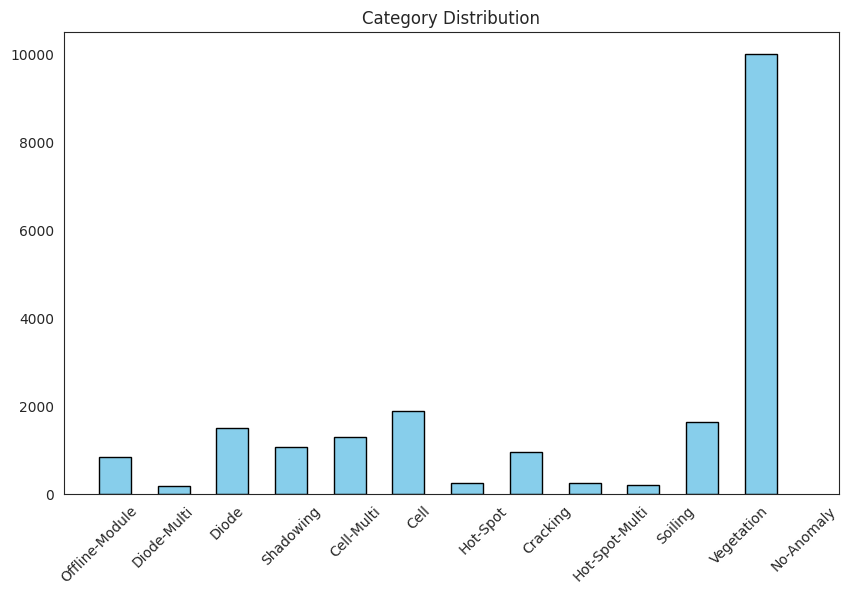

In [9]:
from IPython.core.pylabtools import figsize
import seaborn as sns
sns.set_style("white")

figsize(10, 6)
plt.hist(df["anomaly_class"], color='skyblue', edgecolor='black', bins = 12, width = 0.5, rwidth = 1)
plt.title('Category Distribution')
plt.xticks(rotation = 45)

plt.show()

## Create Train, Validation and Test DF

In [10]:
# Split data into df with 0.8/0.1/0.1 ratio

reduced_df = df.sample(frac = 1, random_state = 200) # random -> seed value
train_df = reduced_df.sample(frac = 0.8,random_state = 200)
validation_test_df = reduced_df.drop(train_df.index)
validation_df = validation_test_df.sample(frac = 0.5,random_state = 200)

test_df=validation_test_df.drop(validation_df.index)

print(train_df.info())
print(validation_df.info())

test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16000 entries, 6173 to 19483
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filepath  16000 non-null  object
 1   anomaly_class   16000 non-null  object
 2   image_name      16000 non-null  object
dtypes: object(3)
memory usage: 500.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 11758 to 6277
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filepath  2000 non-null   object
 1   anomaly_class   2000 non-null   object
 2   image_name      2000 non-null   object
dtypes: object(3)
memory usage: 62.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 8571 to 11343
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filepath  2000 non-null   object
 1  

In [11]:
# Set up train, validation and test generator

image_height = 40
image_width = 24
batch_size = 32
datagen_train=ImageDataGenerator(rescale=1./255)
datagen_validation=ImageDataGenerator(rescale=1./255)


train_generator = datagen_train.flow_from_dataframe(
    dataframe = train_df,
    directory = "/content/InfraredSolarModules/images/",
    x_col = "image_name",
    y_col = "anomaly_class",
    class_mode = "categorical",
    target_size = (image_height, image_width),
    batch_size = batch_size,
    color_mode = "grayscale",
    shuffle = False
)

validation_generator = datagen_validation.flow_from_dataframe(
    dataframe = validation_df,
    directory = "/content/InfraredSolarModules/images/",
    x_col = "image_name",
    y_col = "anomaly_class",
    class_mode = "categorical",
    target_size = (image_height, image_width),
    batch_size = batch_size,
    color_mode = "grayscale",
    shuffle = False
)

test_generator = datagen_validation.flow_from_dataframe(
    dataframe = test_df,
    directory = "/content/InfraredSolarModules/images/",
    x_col = "image_name",
    y_col = "anomaly_class",
    class_mode = "categorical",
    target_size = (image_height, image_width),
    batch_size = batch_size,
    color_mode = "grayscale",
    shuffle = False
)


Found 16000 validated image filenames belonging to 12 classes.
Found 2000 validated image filenames belonging to 12 classes.
Found 2000 validated image filenames belonging to 12 classes.




# CNN Model 1

## Build model 1

In [12]:
# Build CNN model

image_height = 40
image_width = 24
num_classes = 12

model_1 = Sequential()
model_1.add(Conv2D(filters = 32, kernel_size=(3,3), input_shape=(image_height, image_width, 1)))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size= (2,2)))

model_1.add(Conv2D(filters = 64, kernel_size=(3,3)))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size = (2,2)))

model_1.add(Conv2D(filters = 128, kernel_size=(3,3)))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size = (2,2)))

model_1.add(Flatten())
model_1.add(Dense(num_classes))
model_1.add(Activation('softmax'))

model_1.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(1e-3),
              metrics=['accuracy'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 22, 32)        320       
                                                                 
 activation (Activation)     (None, 38, 22, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 19, 11, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 9, 64)         18496     
                                                                 
 activation_1 (Activation)   (None, 17, 9, 64)         0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 4, 64)          0         
 g2D)                                                   

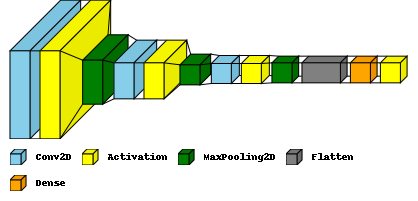

In [13]:
# Visualize Model

visualkeras.layered_view(model_1, legend=True) # without custom font

color_map = defaultdict(dict) #customize the colours
color_map[layers.Conv2D]['fill'] = 'skyblue'
color_map[layers.MaxPooling2D]['fill'] = 'green'
color_map[layers.Dropout]['fill'] = 'black'
color_map[layers.Dense]['fill'] = 'orange'
color_map[layers.Flatten]['fill'] = 'grey'
color_map[layers.Activation]['fill'] = 'yellow'
visualkeras.layered_view(model_1, legend=True, color_map=color_map)

## Train Model 1

In [14]:
history_1 = model_1.fit(
    train_generator,
    epochs = 50,
    validation_data = validation_generator
 )

#model_1.save("/content/drive/My Drive/Colab Notebooks/models/pv_classification/model_1")

Epoch 1/50
500/500 [==============================] - 10s 16ms/step - loss: 1.8010 - accuracy: 0.4996 - val_loss: 1.8028 - val_accuracy: 0.4870
Epoch 2/50
500/500 [==============================] - 12s 24ms/step - loss: 1.7380 - accuracy: 0.5002 - val_loss: 1.8507 - val_accuracy: 0.4515
Epoch 3/50
500/500 [==============================] - 14s 27ms/step - loss: 1.6822 - accuracy: 0.5011 - val_loss: 1.6409 - val_accuracy: 0.4960
Epoch 4/50
500/500 [==============================] - 8s 17ms/step - loss: 1.5301 - accuracy: 0.5436 - val_loss: 1.5681 - val_accuracy: 0.5275
Epoch 5/50
500/500 [==============================] - 12s 24ms/step - loss: 1.3505 - accuracy: 0.5979 - val_loss: 1.2938 - val_accuracy: 0.6120
Epoch 6/50
500/500 [==============================] - 10s 20ms/step - loss: 1.2456 - accuracy: 0.6286 - val_loss: 1.2438 - val_accuracy: 0.6315
Epoch 7/50
500/500 [==============================] - 11s 23ms/step - loss: 1.1938 - accuracy: 0.6374 - val_loss: 1.2372 - val_accuracy: 

## Training Performance

<ipython-input-83-c8173b950d7f>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, accuracy, "bo", label = "Training accuracy", color = "skyblue")
<ipython-input-83-c8173b950d7f>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_accuracy, "b", label = "Validation accuracy",color = "orange")
<ipython-input-83-c8173b950d7f>:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, "bo", label = "Training loss", color = "skyblue")
<ipython-input-83-c8173b950d7f>:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). T

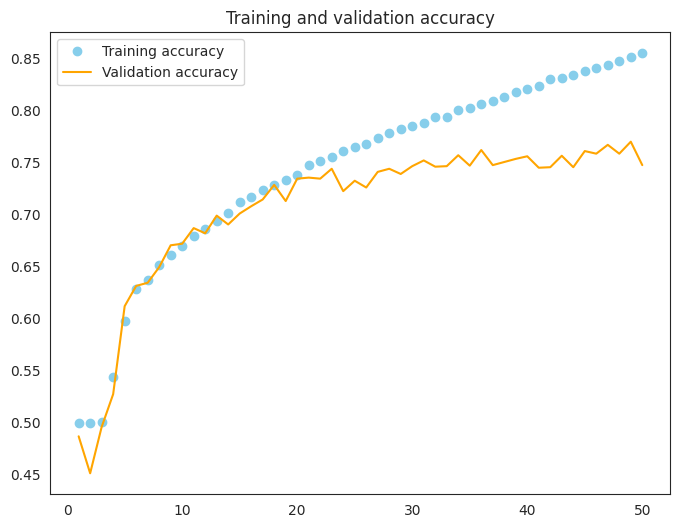

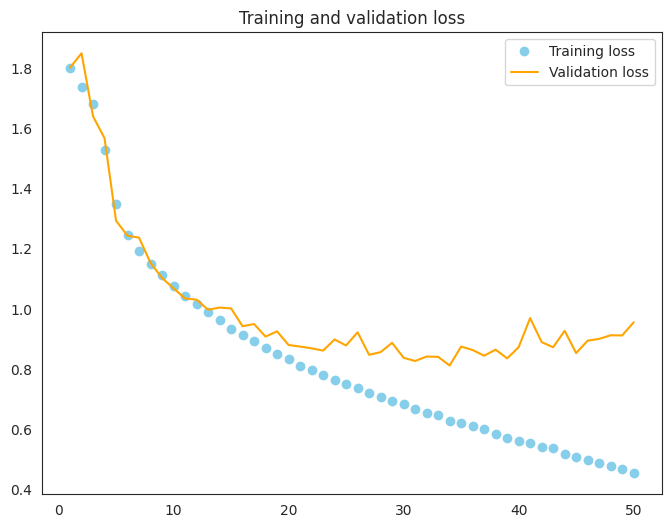

In [83]:
plt.figure(figsize = (8,6))
accuracy = history_1.history["accuracy"]
val_accuracy = history_1.history["val_accuracy"]
loss = history_1.history["loss"]
val_loss = history_1.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label = "Training accuracy", color = "skyblue")
plt.plot(epochs, val_accuracy, "b", label = "Validation accuracy",color = "orange")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure(figsize = (8,6))
plt.plot(epochs, loss, "bo", label = "Training loss", color = "skyblue")
plt.plot(epochs, val_loss, "b", label="Validation loss", color = "orange")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [18]:
model_1.evaluate(test_generator)

63/63 [==============================] - 1s 13ms/step - loss: 0.9584 - accuracy: 0.7390


[0.9584009051322937, 0.7390000224113464]

## Confusion Matrix

In [16]:
x = list(train_generator.class_indices.keys())
num_of_test_samples = 2000

Y_pred = model_1.predict_generator(test_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print()
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

print()
print('Classification Report')
target_names = x
print(classification_report(test_generator.classes, y_pred, target_names = target_names))


<ipython-input-16-a97f8682528a>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model_1.predict_generator(test_generator, num_of_test_samples // batch_size+1)



Confusion Matrix
[[ 71  42   5   2   0   3   0  26   4   6   5  18]
 [ 18  60  14   1   0   4   0  12   3   7   4  18]
 [  1  28  32   2   0   0   2   2   0   4   8   6]
 [  0   0   0 143   0   0   0   5   0   1   0   0]
 [  0   0   0   3   9   0   0   2   4   0   0   0]
 [  1   0   0   1   0  11   2   7   1   0   0   2]
 [  0   1   0   2   0   8  11   3   0   1   0   0]
 [  4   0   1   8   1  10   3 963  20   4   1   2]
 [  2   1   1   3   0   0   1  36  48   1   0   0]
 [  1   3   1   1   0   2   5  33   3  43   1   5]
 [  0   1   1   0   0   1   2   1   0   3   6   0]
 [ 14  25   3   0   0   0   0  19   5   2   2  81]]

Classification Report
                precision    recall  f1-score   support

          Cell       0.63      0.39      0.48       182
    Cell-Multi       0.37      0.43      0.40       141
      Cracking       0.55      0.38      0.45        85
         Diode       0.86      0.96      0.91       149
   Diode-Multi       0.90      0.50      0.64        18
      Hot

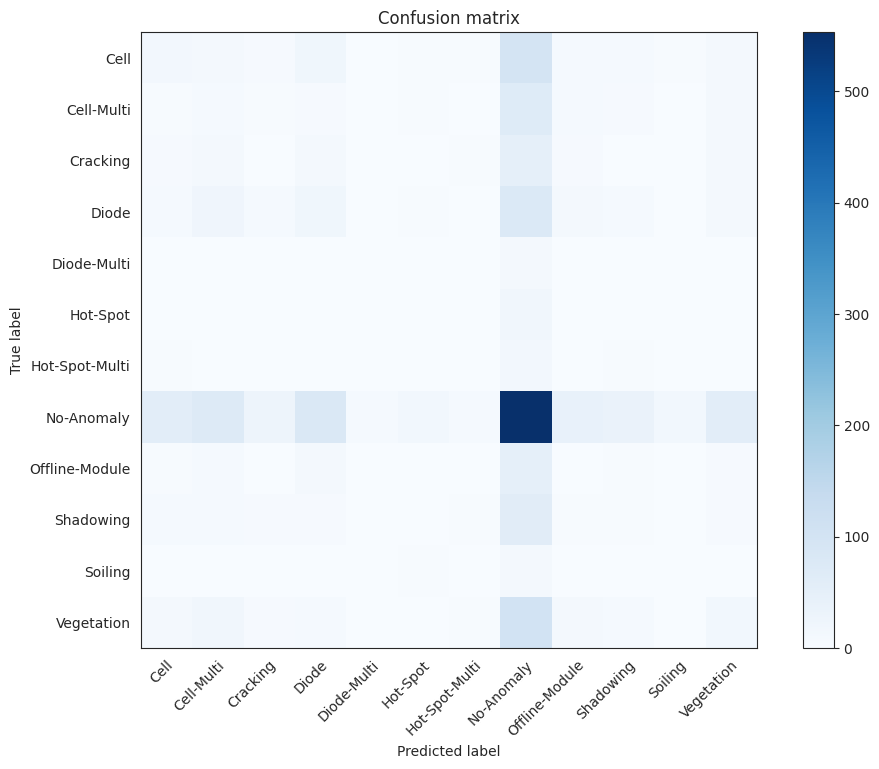

In [17]:
cm = confusion_matrix(validation_generator.classes, y_pred)
fig, ax = plt.subplots(figsize = (12,8))
im = ax.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
title = 'Confusion matrix'
ax.figure.colorbar(im, ax = ax)
ax.set(xticks = np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels = target_names, yticklabels = target_names,
    title=title,
    ylabel ='True label',
    xlabel ='Predicted label',
    )
plt.setp(ax.get_xticklabels(), rotation=45, ha = "right",
             rotation_mode = "anchor")
np.set_printoptions(precision = 2)
plt.show()

# CNN Model 2 - Dropout

## Build Model 2

In [37]:
# build the CNN with dropout 0.5

batch_size = 32
image_height = 40
image_width = 24
num_classes = 12

model_2 = Sequential()
model_2.add(Conv2D(filters = 32, kernel_size=(3,3), input_shape=(image_height, image_width, 1)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size= (2,2)))

model_2.add(Conv2D(filters = 64, kernel_size=(3,3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size = (2,2)))

model_2.add(Conv2D(filters = 128, kernel_size=(3,3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size = (2,2)))

model_2.add(Flatten())
model_2.add(Dropout(0.5))
model_2.add(Dense(num_classes))
model_2.add(Activation('softmax'))

model_2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(1e-3),
              metrics=['accuracy'])
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 38, 22, 32)        320       
                                                                 
 activation_16 (Activation)  (None, 38, 22, 32)        0         
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 19, 11, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 17, 9, 64)         18496     
                                                                 
 activation_17 (Activation)  (None, 17, 9, 64)         0         
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 8, 4, 64)          0         
 ng2D)                                                

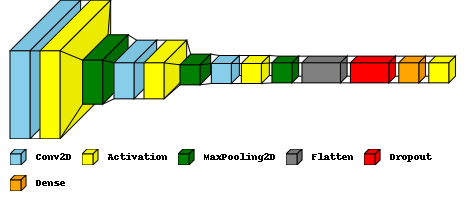

In [38]:
# Visualize Model

visualkeras.layered_view(model_2, legend=True)

color_map = defaultdict(dict)
color_map[layers.Conv2D]['fill'] = 'skyblue'
color_map[layers.MaxPooling2D]['fill'] = 'green'
color_map[layers.Dropout]['fill'] = 'red'
color_map[layers.Dense]['fill'] = 'orange'
color_map[layers.Flatten]['fill'] = 'grey'
color_map[layers.Activation]['fill'] = 'yellow'
visualkeras.layered_view(model_2, legend=True, color_map = color_map)

## Train Model 2

In [39]:
history_2 = model_2.fit(
    train_generator,
    epochs = 80,
    validation_data = validation_generator
 )

#model_2.save("/content/drive/My Drive/Colab Notebooks/models/pv_classification/model_2")

Epoch 1/80
500/500 [==============================] - 8s 14ms/step - loss: 1.8102 - accuracy: 0.4997 - val_loss: 1.7769 - val_accuracy: 0.4870
Epoch 2/80
500/500 [==============================] - 7s 13ms/step - loss: 1.7542 - accuracy: 0.5006 - val_loss: 1.7593 - val_accuracy: 0.4870
Epoch 3/80
500/500 [==============================] - 8s 15ms/step - loss: 1.7262 - accuracy: 0.5006 - val_loss: 1.8815 - val_accuracy: 0.4580
Epoch 4/80
500/500 [==============================] - 6s 13ms/step - loss: 1.6558 - accuracy: 0.5076 - val_loss: 1.7148 - val_accuracy: 0.4925
Epoch 5/80
500/500 [==============================] - 6s 13ms/step - loss: 1.5428 - accuracy: 0.5413 - val_loss: 1.4600 - val_accuracy: 0.5525
Epoch 6/80
500/500 [==============================] - 8s 16ms/step - loss: 1.4290 - accuracy: 0.5798 - val_loss: 1.4150 - val_accuracy: 0.5785
Epoch 7/80
500/500 [==============================] - 7s 15ms/step - loss: 1.3513 - accuracy: 0.5992 - val_loss: 1.2955 - val_accuracy: 0.6125

## Model 2 Training Performance

<ipython-input-84-342452a6b477>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, accuracy, "bo", label = "Training accuracy", color = "skyblue")
<ipython-input-84-342452a6b477>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_accuracy, "b", label = "Validation accuracy",color = "orange")
<ipython-input-84-342452a6b477>:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, "bo", label = "Training loss", color = "skyblue")
<ipython-input-84-342452a6b477>:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). T

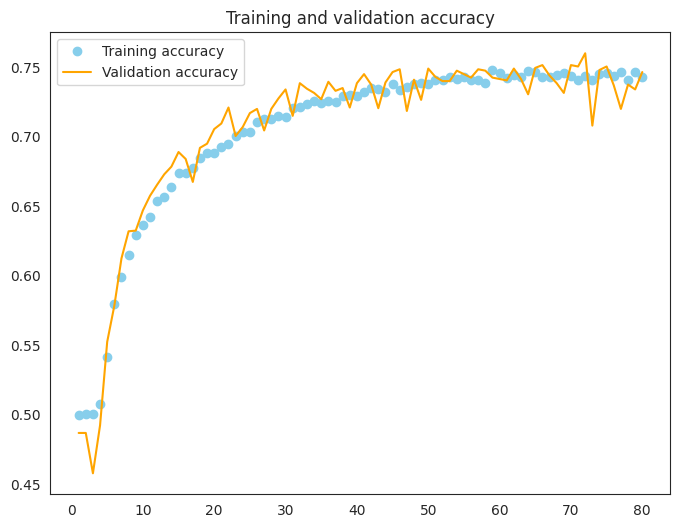

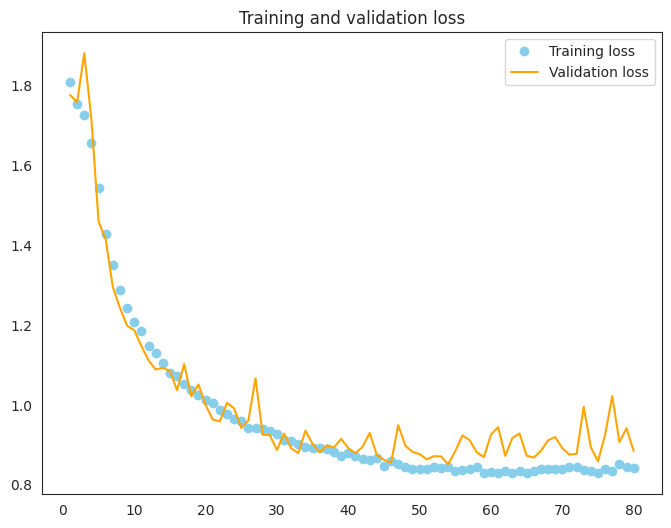

In [84]:
plt.figure(figsize = (8,6))
accuracy = history_2.history["accuracy"]
val_accuracy = history_2.history["val_accuracy"]
loss = history_2.history["loss"]
val_loss = history_2.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label = "Training accuracy", color = "skyblue")
plt.plot(epochs, val_accuracy, "b", label = "Validation accuracy",color = "orange")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure(figsize = (8,6))
plt.plot(epochs, loss, "bo", label = "Training loss", color = "skyblue")
plt.plot(epochs, val_loss, "b", label="Validation loss", color = "orange")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [43]:
model_2.evaluate(test_generator)

63/63 [==============================] - 1s 11ms/step - loss: 0.8411 - accuracy: 0.7525


[0.8410974740982056, 0.7524999976158142]

## Confusion Matrix

In [41]:
x = list(train_generator.class_indices.keys())
num_of_test_samples = 2000

Y_pred = model_2.predict_generator(test_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print()
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

print()
print('Classification Report')
target_names = x
print(classification_report(test_generator.classes, y_pred, target_names = target_names))

<ipython-input-41-8fd743482357>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model_2.predict_generator(test_generator, num_of_test_samples // batch_size+1)



Confusion Matrix
[[116  15   0   0   0   0   0  26   1   5   0  19]
 [ 43  55  17   3   0   0   1   8   0   3   0  11]
 [  5  12  55   1   0   0   3   2   0   2   1   4]
 [  1   0   0 140   0   0   0   7   0   0   0   1]
 [  0   0   0   2  13   0   0   2   1   0   0   0]
 [  4   1   0   0   0   5   0   9   2   3   0   1]
 [  0   0   1   6   0   3   7   5   1   2   0   1]
 [ 10   2   0  12   0   0   1 969   4  12   0   7]
 [  7   0   0   2   0   0   0  55  28   0   0   1]
 [  3   6   3   2   0   1   3  38   1  39   0   2]
 [  4   3   3   0   0   0   1   1   0   1   2   0]
 [ 37  12   3   0   1   0   0  18   1   3   0  76]]

Classification Report
                precision    recall  f1-score   support

          Cell       0.50      0.64      0.56       182
    Cell-Multi       0.52      0.39      0.45       141
      Cracking       0.67      0.65      0.66        85
         Diode       0.83      0.94      0.88       149
   Diode-Multi       0.93      0.72      0.81        18
      Hot

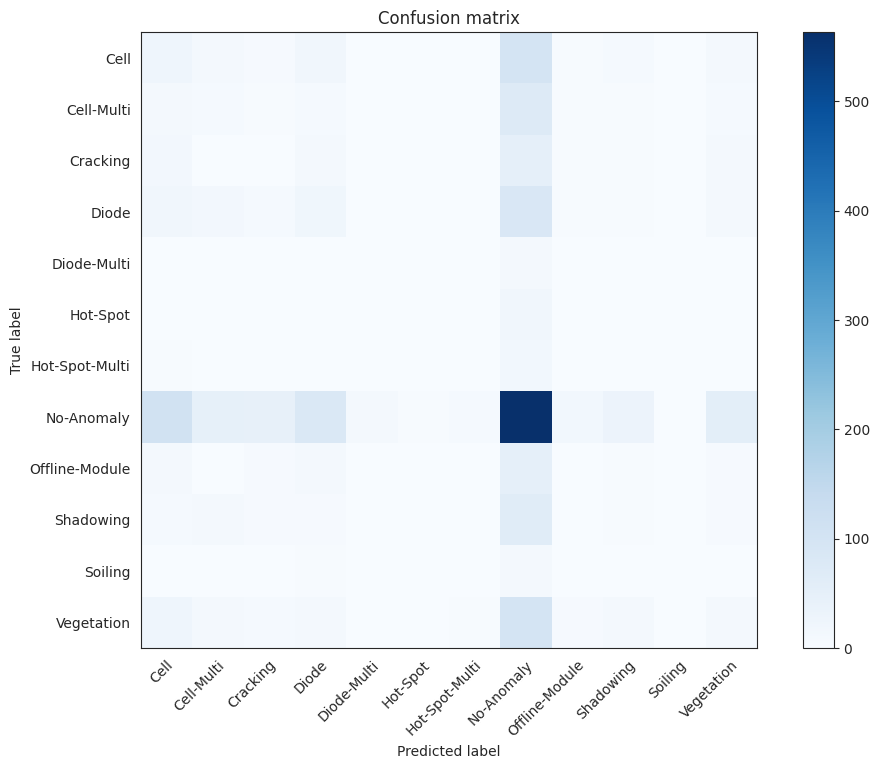

In [42]:
cm = confusion_matrix(validation_generator.classes, y_pred)
fig, ax = plt.subplots(figsize = (12,8))
im = ax.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
title = 'Confusion matrix'
ax.figure.colorbar(im, ax = ax)
ax.set(xticks = np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels = target_names, yticklabels = target_names,
    title=title,
    ylabel ='True label',
    xlabel ='Predicted label',
    )
plt.setp(ax.get_xticklabels(), rotation=45, ha = "right",
             rotation_mode = "anchor")
np.set_printoptions(precision = 2)
plt.show()

# CNN Model 3 - Dropout & AdamW Optimizer

## Build Model 3

In [48]:
# build the CNN with dropout 0.5 and AdamW at 0.001

batch_size = 32
image_height = 40
image_width = 24
num_classes = 12

model_3 = Sequential()
model_3.add(Conv2D(filters = 32, kernel_size=(3,3), input_shape=(image_height, image_width, 1)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size= (2,2)))

model_3.add(Conv2D(filters = 64, kernel_size=(3,3)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size = (2,2)))

model_3.add(Conv2D(filters = 128, kernel_size=(3,3)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size = (2,2)))

model_3.add(Flatten())
model_3.add(Dropout(0.5))
model_3.add(Dense(num_classes))
model_3.add(Activation('softmax'))

model_3.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.AdamW(1e-3),
              metrics=['accuracy'])
model_3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 38, 22, 32)        320       
                                                                 
 activation_24 (Activation)  (None, 38, 22, 32)        0         
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 19, 11, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 17, 9, 64)         18496     
                                                                 
 activation_25 (Activation)  (None, 17, 9, 64)         0         
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 8, 4, 64)          0         
 ng2D)                                                

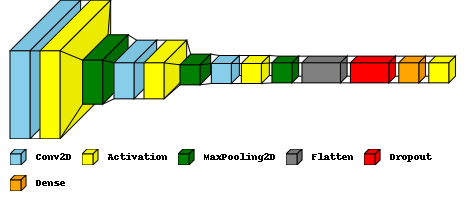

In [51]:
# Visualize Model

visualkeras.layered_view(model_3, legend=True)

color_map = defaultdict(dict)
color_map[layers.Conv2D]['fill'] = 'skyblue'
color_map[layers.MaxPooling2D]['fill'] = 'green'
color_map[layers.Dropout]['fill'] = 'red'
color_map[layers.Dense]['fill'] = 'orange'
color_map[layers.Flatten]['fill'] = 'grey'
color_map[layers.Activation]['fill'] = 'yellow'
visualkeras.layered_view(model_3, legend=True, color_map = color_map)

## Train Model 3


In [50]:
history_3 = model_3.fit(
    train_generator,
    epochs = 80,
    validation_data = validation_generator
 )

model_3.save("/content/drive/My Drive/Colab Notebooks/models/pv_classification/model_3")

Epoch 1/80
500/500 [==============================] - 11s 17ms/step - loss: 1.8140 - accuracy: 0.4996 - val_loss: 1.7952 - val_accuracy: 0.4870
Epoch 2/80
500/500 [==============================] - 8s 16ms/step - loss: 1.7614 - accuracy: 0.5006 - val_loss: 1.7671 - val_accuracy: 0.4870
Epoch 3/80
500/500 [==============================] - 7s 14ms/step - loss: 1.7467 - accuracy: 0.5005 - val_loss: 1.7793 - val_accuracy: 0.4870
Epoch 4/80
500/500 [==============================] - 8s 16ms/step - loss: 1.7387 - accuracy: 0.5004 - val_loss: 1.7558 - val_accuracy: 0.4870
Epoch 5/80
500/500 [==============================] - 7s 15ms/step - loss: 1.7208 - accuracy: 0.5002 - val_loss: 1.7506 - val_accuracy: 0.4855
Epoch 6/80
500/500 [==============================] - 7s 14ms/step - loss: 1.7055 - accuracy: 0.4999 - val_loss: 1.7283 - val_accuracy: 0.4810
Epoch 7/80
500/500 [==============================] - 8s 16ms/step - loss: 1.6792 - accuracy: 0.5002 - val_loss: 1.6577 - val_accuracy: 0.491

## Model 3 Training Performance

<ipython-input-85-01195d3e61a7>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, accuracy, "bo", label = "Training accuracy", color = "skyblue")
<ipython-input-85-01195d3e61a7>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_accuracy, "b", label = "Validation accuracy",color = "orange")
<ipython-input-85-01195d3e61a7>:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, "bo", label = "Training loss", color = "skyblue")
<ipython-input-85-01195d3e61a7>:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). T

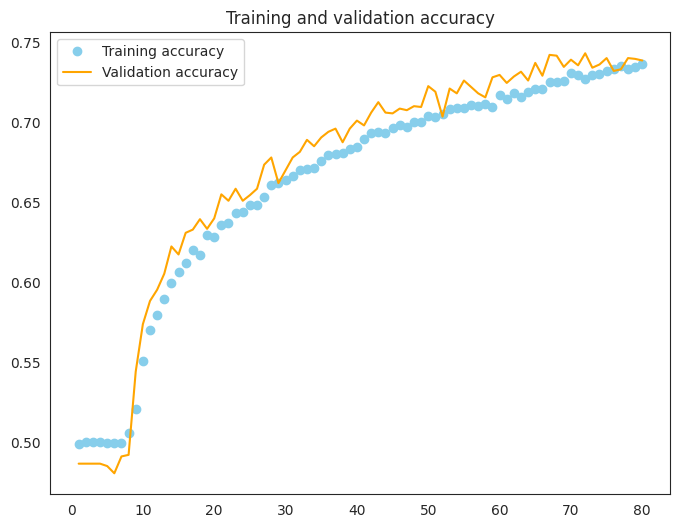

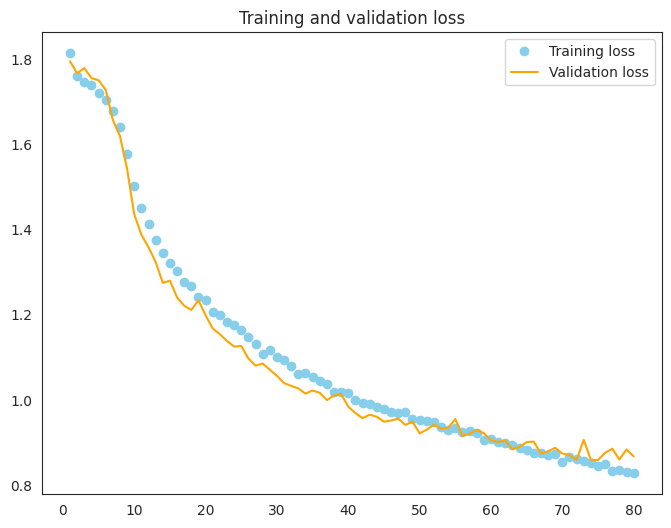

In [85]:
plt.figure(figsize = (8,6))
accuracy = history_3.history["accuracy"]
val_accuracy = history_3.history["val_accuracy"]
loss = history_3.history["loss"]
val_loss = history_3.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label = "Training accuracy", color = "skyblue")
plt.plot(epochs, val_accuracy, "b", label = "Validation accuracy",color = "orange")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure(figsize = (8,6))
plt.plot(epochs, loss, "bo", label = "Training loss", color = "skyblue")
plt.plot(epochs, val_loss, "b", label="Validation loss", color = "orange")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [33]:
model_3.evaluate(test_generator)

63/63 [==============================] - 1s 11ms/step - loss: 0.9029 - accuracy: 0.7215


[0.9028711915016174, 0.7214999794960022]

## Confusion Matrix

In [53]:
x = list(train_generator.class_indices.keys())
num_of_test_samples = 2000

Y_pred = model_3.predict_generator(test_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print()
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

print()
print('Classification Report')
target_names = x
print(classification_report(test_generator.classes, y_pred, target_names = target_names))

<ipython-input-53-212c987aa16e>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model_3.predict_generator(test_generator, num_of_test_samples // batch_size+1)



Confusion Matrix
[[ 117    8    2    0    0    0    0   40    0    3    0   12]
 [  47   36   21    1    0    0    0   16    0    4    0   16]
 [   2   17   58    0    0    0    3    3    0    0    0    2]
 [   1    0    0  127    1    0    0   20    0    0    0    0]
 [   1    0    0    3    8    0    0    6    0    0    0    0]
 [   1    0    0    0    0    3    1   19    0    0    0    1]
 [   0    0    0    2    1    2    9   11    0    0    0    1]
 [   5    0    0    3    0    0    0 1004    0    2    1    2]
 [   1    0    0    0    0    0    0   75   16    0    0    1]
 [   3    4    3    1    1    0    1   47    0   37    0    1]
 [   4    1    3    0    0    0    1    1    0    3    2    0]
 [  44   12    2    1    0    0    0   28    0    0    1   63]]

Classification Report
                precision    recall  f1-score   support

          Cell       0.52      0.64      0.57       182
    Cell-Multi       0.46      0.26      0.33       141
      Cracking       0.65      0.

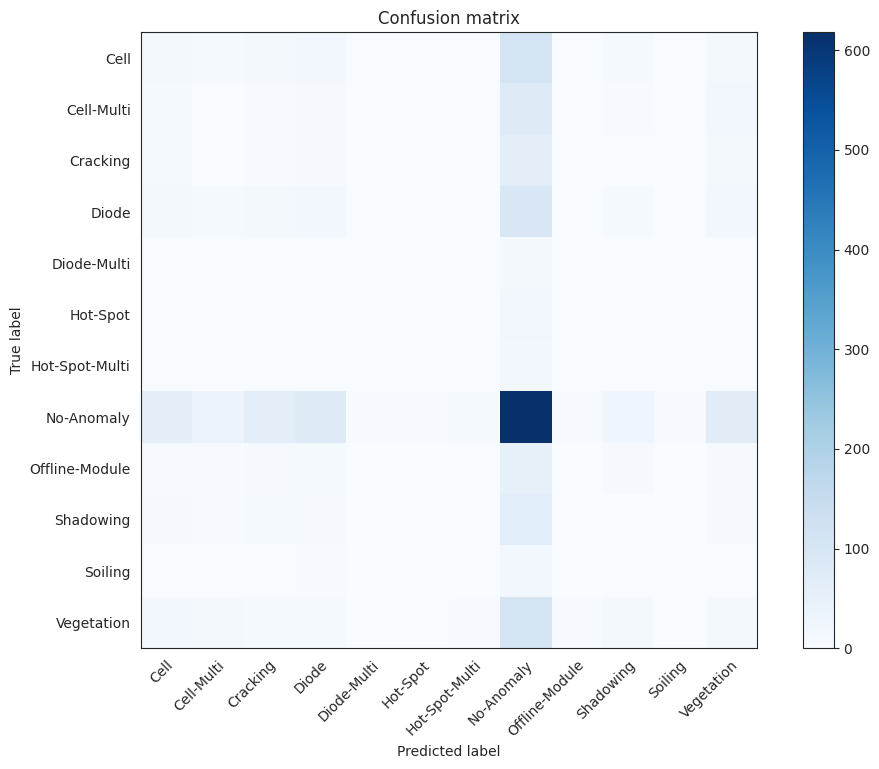

In [32]:
cm = confusion_matrix(validation_generator.classes, y_pred)
fig, ax = plt.subplots(figsize = (12,8))
im = ax.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
title = 'Confusion matrix'
ax.figure.colorbar(im, ax = ax)
ax.set(xticks = np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels = target_names, yticklabels = target_names,
    title=title,
    ylabel ='True label',
    xlabel ='Predicted label',
    )
plt.setp(ax.get_xticklabels(), rotation=45, ha = "right",
             rotation_mode = "anchor")
np.set_printoptions(precision = 2)
plt.show()

# CNN Model 4 - Dropout & AdamW Optimizer

## Build Model 4

In [54]:
# build the CNN with dropout 0.5 and AdamW at 0.001

batch_size = 32
image_height = 40
image_width = 24
num_classes = 12

model_4 = Sequential()
model_4.add(Conv2D(filters = 32, kernel_size=(3,3), input_shape=(image_height, image_width, 1)))
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size= (2,2)))

model_4.add(Conv2D(filters = 64, kernel_size=(3,3)))
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size = (2,2)))

model_4.add(Conv2D(filters = 128, kernel_size=(3,3)))
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size = (2,2)))

model_4.add(Flatten())
model_4.add(Dropout(0.25))
model_4.add(Dense(num_classes))
model_4.add(Activation('softmax'))

model_4.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.AdamW(1e-3),
              metrics=['accuracy'])
model_4.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 38, 22, 32)        320       
                                                                 
 activation_28 (Activation)  (None, 38, 22, 32)        0         
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 19, 11, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 17, 9, 64)         18496     
                                                                 
 activation_29 (Activation)  (None, 17, 9, 64)         0         
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 8, 4, 64)          0         
 ng2D)                                                

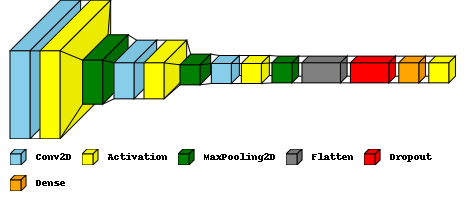

In [55]:
# Visualize Model

visualkeras.layered_view(model_4, legend=True)

color_map = defaultdict(dict)
color_map[layers.Conv2D]['fill'] = 'skyblue'
color_map[layers.MaxPooling2D]['fill'] = 'green'
color_map[layers.Dropout]['fill'] = 'red'
color_map[layers.Dense]['fill'] = 'orange'
color_map[layers.Flatten]['fill'] = 'grey'
color_map[layers.Activation]['fill'] = 'yellow'
visualkeras.layered_view(model_4, legend=True, color_map = color_map)

## Train Model 4


In [56]:
history_4 = model_4.fit(
    train_generator,
    epochs = 80,
    validation_data = validation_generator
 )

#model_4.save("/content/drive/My Drive/Colab Notebooks/models/pv_classification/model_4")

Epoch 1/80
500/500 [==============================] - 10s 15ms/step - loss: 1.8116 - accuracy: 0.4998 - val_loss: 1.8030 - val_accuracy: 0.4870
Epoch 2/80
500/500 [==============================] - 8s 17ms/step - loss: 1.7564 - accuracy: 0.5006 - val_loss: 1.7654 - val_accuracy: 0.4870
Epoch 3/80
500/500 [==============================] - 7s 14ms/step - loss: 1.7436 - accuracy: 0.5006 - val_loss: 1.7645 - val_accuracy: 0.4870
Epoch 4/80
500/500 [==============================] - 8s 17ms/step - loss: 1.7374 - accuracy: 0.5006 - val_loss: 1.7605 - val_accuracy: 0.4870
Epoch 5/80
500/500 [==============================] - 7s 14ms/step - loss: 1.7258 - accuracy: 0.5006 - val_loss: 1.7465 - val_accuracy: 0.4870
Epoch 6/80
500/500 [==============================] - 8s 17ms/step - loss: 1.7184 - accuracy: 0.5006 - val_loss: 1.7627 - val_accuracy: 0.4870
Epoch 7/80
500/500 [==============================] - 8s 16ms/step - loss: 1.7044 - accuracy: 0.5006 - val_loss: 1.7248 - val_accuracy: 0.487

## Model 4 Training Performance

<ipython-input-86-7b16ec24e35d>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, accuracy, "bo", label = "Training accuracy", color = "skyblue")
<ipython-input-86-7b16ec24e35d>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_accuracy, "b", label = "Validation accuracy",color = "orange")
<ipython-input-86-7b16ec24e35d>:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, "bo", label = "Training loss", color = "skyblue")
<ipython-input-86-7b16ec24e35d>:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). T

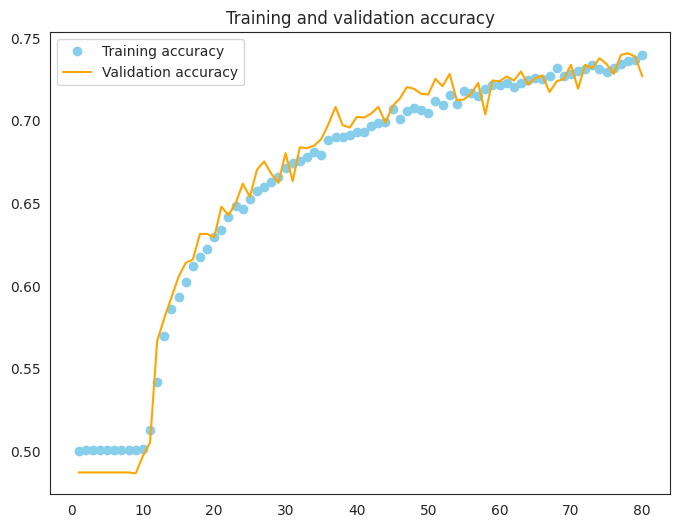

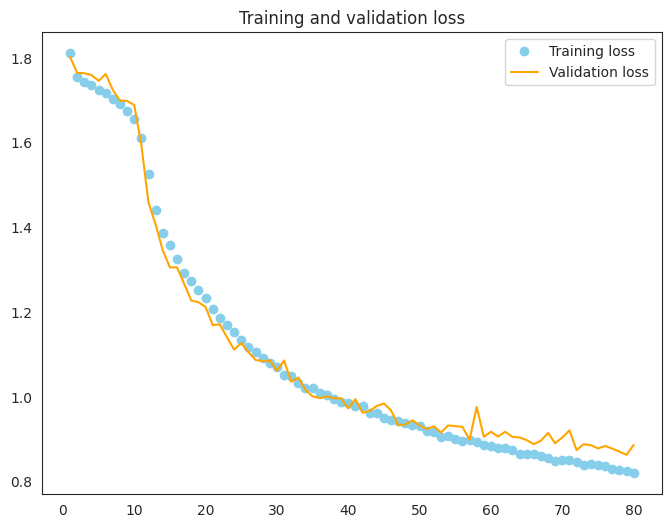

In [86]:
plt.figure(figsize = (8,6))
accuracy = history_4.history["accuracy"]
val_accuracy = history_4.history["val_accuracy"]
loss = history_4.history["loss"]
val_loss = history_4.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label = "Training accuracy", color = "skyblue")
plt.plot(epochs, val_accuracy, "b", label = "Validation accuracy",color = "orange")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure(figsize = (8,6))
plt.plot(epochs, loss, "bo", label = "Training loss", color = "skyblue")
plt.plot(epochs, val_loss, "b", label="Validation loss", color = "orange")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [59]:
model_4.evaluate(test_generator)

63/63 [==============================] - 1s 11ms/step - loss: 0.8416 - accuracy: 0.7315


[0.8415918946266174, 0.7315000295639038]

## Confusion Matrix

In [60]:
x = list(train_generator.class_indices.keys())
num_of_test_samples = 2000

Y_pred = model_4.predict_generator(test_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print()
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

print()
print('Classification Report')
target_names = x
print(classification_report(test_generator.classes, y_pred, target_names = target_names))

<ipython-input-60-2465422c318f>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model_4.predict_generator(test_generator, num_of_test_samples // batch_size+1)



Confusion Matrix
[[ 97  10   1   0   0   2   0  39   0   5   2  26]
 [ 41  35  17   2   0   1   0  12   0  10   3  20]
 [  5  19  41   1   1   0   1   4   0   3   1   9]
 [  0   0   0 133   1   0   0  15   0   0   0   0]
 [  0   0   0   3  10   0   0   4   1   0   0   0]
 [  2   0   0   0   0   4   1  16   0   1   0   1]
 [  0   0   1   0   2   3   7  11   0   1   0   1]
 [  6   0   0   3   0   0   1 995   1   5   0   6]
 [  5   0   0   1   0   0   0  71  15   0   0   1]
 [  3   2   1   2   0   0   1  47   1  37   0   4]
 [  3   2   1   0   0   0   1   4   0   1   2   1]
 [ 25   6   1   0   0   0   0  25   2   3   2  87]]

Classification Report
                precision    recall  f1-score   support

          Cell       0.52      0.53      0.53       182
    Cell-Multi       0.47      0.25      0.33       141
      Cracking       0.65      0.48      0.55        85
         Diode       0.92      0.89      0.90       149
   Diode-Multi       0.71      0.56      0.63        18
      Hot

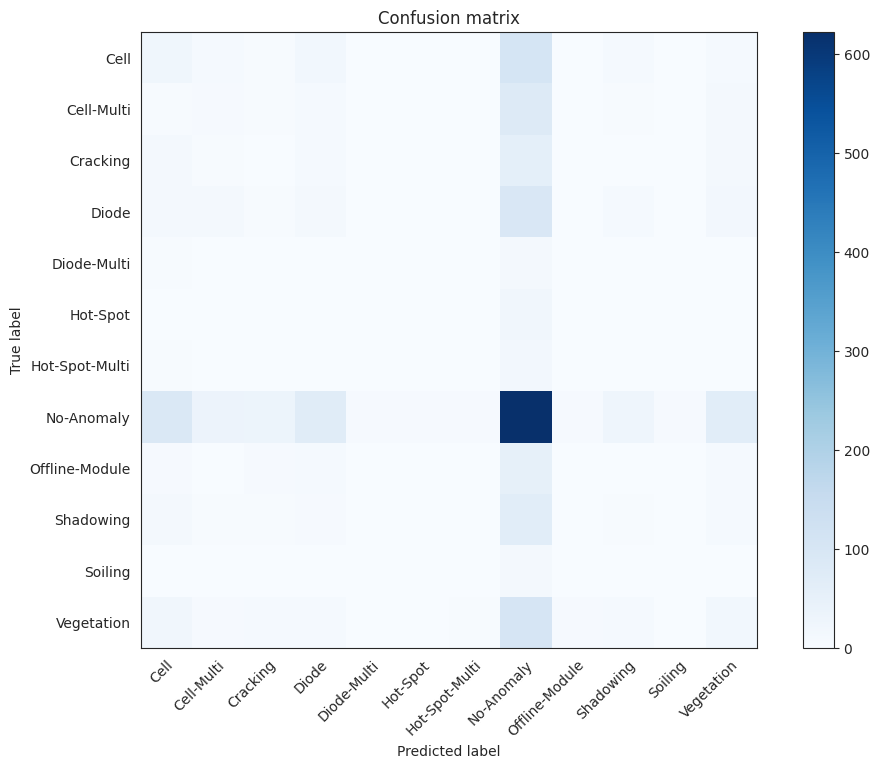

In [61]:
cm = confusion_matrix(validation_generator.classes, y_pred)
fig, ax = plt.subplots(figsize = (12,8))
im = ax.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
title = 'Confusion matrix'
ax.figure.colorbar(im, ax = ax)
ax.set(xticks = np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels = target_names, yticklabels = target_names,
    title=title,
    ylabel ='True label',
    xlabel ='Predicted label',
    )
plt.setp(ax.get_xticklabels(), rotation=45, ha = "right",
             rotation_mode = "anchor")
np.set_printoptions(precision = 2)
plt.show()

# Model 5 - Two-Category Model

## Create Train, Validation and Test DF

In [62]:
df_two_cat = df
df_two_cat['anomaly_class'] = np.where((df_two_cat['anomaly_class'] != 'No-Anomaly'),'Anomaly',df_two_cat['anomaly_class'])
df_two_cat

,image_filepath,anomaly_class,image_name
0,images/0.jpg,Anomaly,0.jpg
1,images/1.jpg,Anomaly,1.jpg
2,images/2.jpg,Anomaly,2.jpg
3,images/3.jpg,Anomaly,3.jpg
4,images/4.jpg,Anomaly,4.jpg
...,...,...,...
19995,images/19995.jpg,No-Anomaly,19995.jpg
19996,images/19996.jpg,No-Anomaly,19996.jpg
19997,images/19997.jpg,No-Anomaly,19997.jpg
19998,images/19998.jpg,No-Anomaly,19998.jpg


In [63]:
# Split data into df with 0.8/0.1/0.1 ratio

reduced_df_two_cat = df_two_cat.sample(frac = 1, random_state = 200) # random -> seed value
train_df_two_cat = reduced_df_two_cat.sample(frac = 0.8,random_state = 200)
validation_test_df_two_cat = reduced_df_two_cat.drop(train_df_two_cat.index)
validation_df_two_cat = validation_test_df_two_cat.sample(frac = 0.5,random_state = 200)

test_df_two_cat=validation_test_df_two_cat.drop(validation_df_two_cat.index)

print(train_df_two_cat.info())
print(validation_df_two_cat.info())

test_df_two_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16000 entries, 6173 to 19483
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filepath  16000 non-null  object
 1   anomaly_class   16000 non-null  object
 2   image_name      16000 non-null  object
dtypes: object(3)
memory usage: 500.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 11758 to 6277
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filepath  2000 non-null   object
 1   anomaly_class   2000 non-null   object
 2   image_name      2000 non-null   object
dtypes: object(3)
memory usage: 62.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 8571 to 11343
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filepath  2000 non-null   object
 1  

In [75]:
# Set up train, validation and test generator

image_height = 40
image_width = 24
batch_size = 32
datagen_train=ImageDataGenerator(rescale = 1./255)
datagen_validation=ImageDataGenerator(rescale = 1./255)


train_generator = datagen_train.flow_from_dataframe(
    dataframe = train_df_two_cat,
    directory = "/content/InfraredSolarModules/images/",
    x_col = "image_name",
    y_col = "anomaly_class",
    class_mode = "categorical",
    target_size = (image_height, image_width),
    batch_size = batch_size,
    color_mode = "grayscale",
    shuffle = False
)

validation_generator = datagen_validation.flow_from_dataframe(
    dataframe = validation_df_two_cat,
    directory = "/content/InfraredSolarModules/images/",
    x_col = "image_name",
    y_col = "anomaly_class",
    class_mode = "categorical",
    target_size = (image_height, image_width),
    batch_size = batch_size,
    color_mode = "grayscale",
    shuffle = False
)

test_generator = datagen_validation.flow_from_dataframe(
    dataframe = test_df_two_cat,
    directory = "/content/InfraredSolarModules/images/",
    x_col = "image_name",
    y_col = "anomaly_class",
    class_mode = "categorical",
    target_size = (image_height, image_width),
    batch_size = batch_size,
    color_mode = "grayscale",
    shuffle = False
)


Found 16000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


## Build Model 5

In [76]:
batch_size = 32
image_height = 40
image_width = 24
num_classes = 2

model_5 = Sequential()
model_5.add(Conv2D(filters = 32, kernel_size=(3,3), input_shape=(image_height, image_width, 1)))
model_5.add(Activation('relu'))
model_5.add(MaxPooling2D(pool_size= (2,2)))

model_5.add(Conv2D(filters = 64, kernel_size=(3,3)))
model_5.add(Activation('relu'))
model_5.add(MaxPooling2D(pool_size = (2,2)))

model_5.add(Conv2D(filters = 128, kernel_size=(3,3)))
model_5.add(Activation('relu'))
model_5.add(MaxPooling2D(pool_size = (2,2)))

model_5.add(Flatten())
model_5.add(Dropout(0.3))
model_5.add(Dense(num_classes))
model_5.add(Activation('softmax'))

model_5.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])
model_5.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 38, 22, 32)        320       
                                                                 
 activation_44 (Activation)  (None, 38, 22, 32)        0         
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 19, 11, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 17, 9, 64)         18496     
                                                                 
 activation_45 (Activation)  (None, 17, 9, 64)         0         
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 8, 4, 64)          0         
 ng2D)                                               

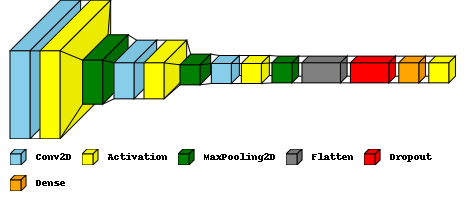

In [73]:
# Visualize Model

visualkeras.layered_view(model_5, legend=True)

color_map = defaultdict(dict)
color_map[layers.Conv2D]['fill'] = 'skyblue'
color_map[layers.MaxPooling2D]['fill'] = 'green'
color_map[layers.Dropout]['fill'] = 'red'
color_map[layers.Dense]['fill'] = 'orange'
color_map[layers.Flatten]['fill'] = 'grey'
color_map[layers.Activation]['fill'] = 'yellow'
visualkeras.layered_view(model_5, legend=True, color_map = color_map)

## Train Model 5

In [77]:
history_5 = model_5.fit(
    train_generator,
    epochs = 80,
    validation_data = validation_generator
 )

#model_5.save("/content/drive/My Drive/Colab Notebooks/models/pv_classification/model_5")

Epoch 1/80
500/500 [==============================] - 13s 20ms/step - loss: 0.6626 - accuracy: 0.5885 - val_loss: 0.5885 - val_accuracy: 0.6655
Epoch 2/80
500/500 [==============================] - 7s 14ms/step - loss: 0.5211 - accuracy: 0.7355 - val_loss: 0.4727 - val_accuracy: 0.7745
Epoch 3/80
500/500 [==============================] - 7s 13ms/step - loss: 0.4616 - accuracy: 0.7782 - val_loss: 0.4623 - val_accuracy: 0.7840
Epoch 4/80
500/500 [==============================] - 8s 16ms/step - loss: 0.4415 - accuracy: 0.7956 - val_loss: 0.4326 - val_accuracy: 0.8020
Epoch 5/80
500/500 [==============================] - 7s 14ms/step - loss: 0.4155 - accuracy: 0.8111 - val_loss: 0.4229 - val_accuracy: 0.8060
Epoch 6/80
500/500 [==============================] - 8s 16ms/step - loss: 0.4021 - accuracy: 0.8214 - val_loss: 0.4120 - val_accuracy: 0.8220
Epoch 7/80
500/500 [==============================] - 7s 14ms/step - loss: 0.3933 - accuracy: 0.8266 - val_loss: 0.4008 - val_accuracy: 0.824

## Model 5 Training Performance

<ipython-input-87-6d5410425a1b>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, accuracy, "bo", label = "Training accuracy", color = "skyblue")
<ipython-input-87-6d5410425a1b>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_accuracy, "b", label = "Validation accuracy",color = "orange")
<ipython-input-87-6d5410425a1b>:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, "bo", label = "Training loss", color = "skyblue")
<ipython-input-87-6d5410425a1b>:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). T

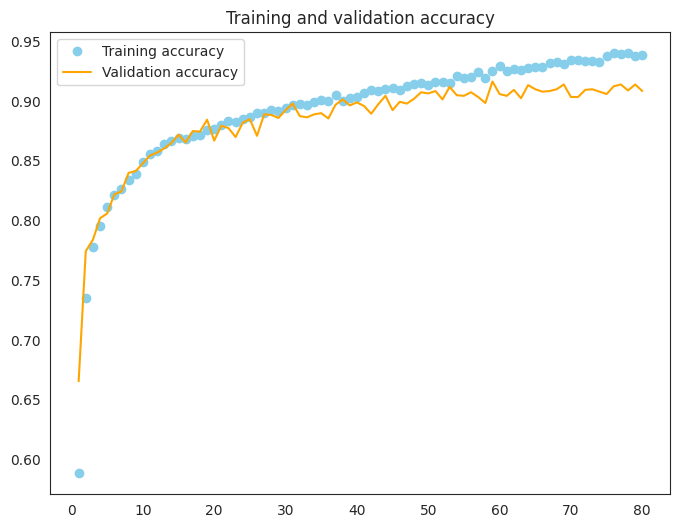

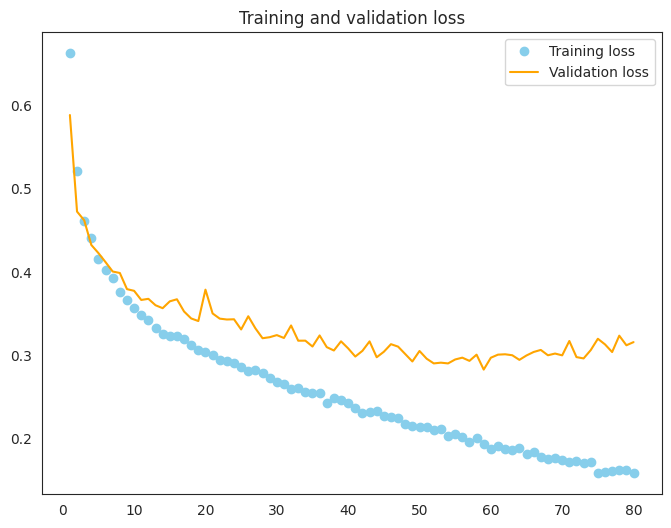

In [87]:
plt.figure(figsize = (8,6))
accuracy = history_5.history["accuracy"]
val_accuracy = history_5.history["val_accuracy"]
loss = history_5.history["loss"]
val_loss = history_5.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label = "Training accuracy", color = "skyblue")
plt.plot(epochs, val_accuracy, "b", label = "Validation accuracy",color = "orange")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure(figsize = (8,6))
plt.plot(epochs, loss, "bo", label = "Training loss", color = "skyblue")
plt.plot(epochs, val_loss, "b", label="Validation loss", color = "orange")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [79]:
model_5.evaluate(test_generator)

63/63 [==============================] - 1s 12ms/step - loss: 0.3016 - accuracy: 0.9085


[0.30164799094200134, 0.9085000157356262]

## Confusion Matrix

In [80]:
x = list(train_generator.class_indices.keys())
num_of_test_samples = 2000

Y_pred = model_5.predict_generator(test_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print()
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

print()
print('Classification Report')
target_names = x
print(classification_report(test_generator.classes, y_pred, target_names = target_names))

<ipython-input-80-9085b97fa0af>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model_5.predict_generator(test_generator, num_of_test_samples // batch_size+1)



Confusion Matrix
[[855 128]
 [ 55 962]]

Classification Report
              precision    recall  f1-score   support

     Anomaly       0.94      0.87      0.90       983
  No-Anomaly       0.88      0.95      0.91      1017

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



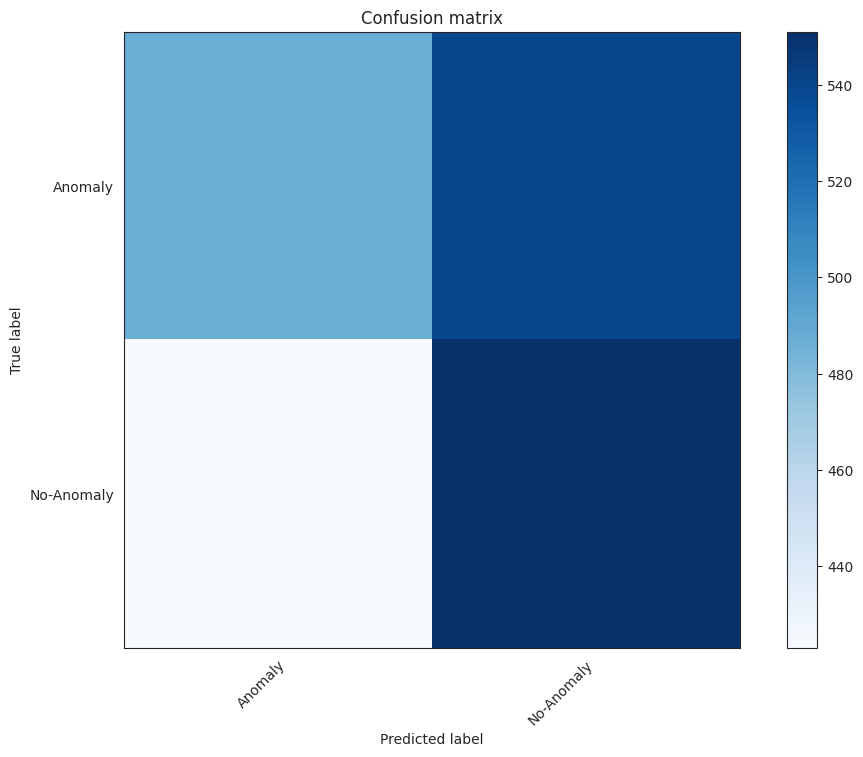

In [81]:
cm = confusion_matrix(validation_generator.classes, y_pred)
fig, ax = plt.subplots(figsize = (12,8))
im = ax.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
title = 'Confusion matrix'
ax.figure.colorbar(im, ax = ax)
ax.set(xticks = np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels = target_names, yticklabels = target_names,
    title=title,
    ylabel ='True label',
    xlabel ='Predicted label',
    )
plt.setp(ax.get_xticklabels(), rotation=45, ha = "right",
             rotation_mode = "anchor")
np.set_printoptions(precision = 2)
plt.show()

s p a c e r

Thoughts and Conclusion

- Transfer learning doesn't improve the model - possibly due to the abstract nature of the data
- Data strongly imbalanced -> maybe do a two stage classification first error vs non error, second only with error categeories